# Cabecera

## Trabajo de curso: Recomendador de Revistas
**Asignatura:** Ciencia de Datos en Ingeniería  
**Autor:** Santiago Santana Martínez  
**Fecha:** 29 de diciembre de 2025
**Entorno:** Jupyter Notebook (Python 3)

## Objetivo del proyecto

En la actualidad el número de revistas científicas es del orden de miles, lo que supone que en un determinado campo puedan existir decenas de revistas. Por tanto, el objetivo que se plantea en este trabajo es realizar un proyecto de Ciencia de Datos con el objetivo de realizar un sistema inteligente que recomiende una revista científica para enviar un artículo para su publicación. De esta forma, el investigador dando el título del trabajo, el resumen y las palabras claves, el sistema le recomendará la revista a la que debería enviar el artículo

# Introducción

En este trabajo se aborda el problema de recomendación de revistas científicas como una tarea de clasificación supervisada de documentos. A partir del título, resumen y palabras clave de un artículo, el sistema predice la revista más adecuada para su publicación. En esta primera parte se emplean técnicas clásicas de procesamiento del lenguaje natural y aprendizaje automático.

# Aproximación Clásica

En esta primera aproximación se aborda el problema de recomendación de revistas mediante técnicas tradicionales de Machine Learning. El objetivo es construir un clasificador supervisado que, dado el texto de un artículo (título + abstract + keywords), prediga la revista más apropiada para su publicación.

**Metodología:**

1. **Representación del texto**: Se utiliza **TF-IDF** (Term Frequency-Inverse Document Frequency) para convertir los textos en vectores numéricos. Esta técnica captura la importancia de las palabras en cada documento sin considerar el orden de las mismas.

2. **Modelos de clasificación**: Se entrenan y comparan tres algoritmos clásicos:
   - **Regresión Logística**: Modelo lineal simple y eficiente
   - **SVM Lineal**: Busca el hiperplano óptimo de separación entre clases
   - **Random Forest**: Conjunto de árboles de decisión para capturar relaciones no lineales

3. **Preprocesamiento alternativo**: Se evalúa el impacto de la **lematización** (reducción de palabras a su forma raíz) en el rendimiento de los modelos.

4. **Validación rigurosa**: Se utiliza validación cruzada estratificada para evaluar la capacidad de generalización y se reserva un conjunto de test para la evaluación final.

Esta aproximación establece una línea base sólida que servirá como referencia para comparar con modelos más sofisticados basados en redes neuronales.

In [40]:
import json
import glob
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

## Carga de los JSON

Los artículos se almacenan en formato JSON, uno por revista y año. Cada entrada contiene el título, resumen, palabras clave y la revista asociada, que se utilizará como etiqueta de clase.

In [41]:
def load_json_folder(folder_path):
    articles = []
    for file in glob.glob(os.path.join(folder_path, "*.json")):
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)
            articles.extend(data)
    return articles

In [42]:
base_path = "Data/raw"

all_articles = []
for journal_folder in os.listdir(base_path):
    folder = os.path.join(base_path, journal_folder)
    if os.path.isdir(folder):
        all_articles.extend(load_json_folder(folder))

print(f"Número total de artículos: {len(all_articles)}")

Número total de artículos: 18066


## Construcción del DataFrame df

Cada artículo se representa como un único documento textual concatenando título, abstract y keywords. Esta decisión permite capturar tanto la información temática general como los términos específicos del dominio.

In [43]:
rows = []

for art in all_articles:
    text_parts = [
        art.get("title", ""),
        art.get("abstract", ""),
        " ".join(art.get("keywords", []))
    ]
    text = " ".join(text_parts)

    rows.append({
        "text": text,
        "journal": art["journal"],
        "year": int(art["year"])
    })

df = pd.DataFrame(rows)
df.head()

,text,journal,year
0,Comparing SNNs and RNNs on neuromorphic vision...,Neural Networks,2020
1,Hybrid tensor decomposition in neural network ...,Neural Networks,2020
2,Exploiting bi-directional global transition pa...,Neural Networks,2020
3,On the robustness of skeleton detection agains...,Neural Networks,2020
4,MGAT: Multi-view Graph Attention Networks Mult...,Neural Networks,2020


## Preprocesamiento de los datos

### Detección de posibles valores perdidos

In [44]:
print("=" * 60)
print("DETECCIÓN DE VALORES PERDIDOS")
print("=" * 60)

missing_in_cols = df.isnull().sum()
print("\nValores nulos por columna:")
print(missing_in_cols)

total_missing = df.isnull().sum().sum()
print(f"\nTotal de valores nulos: {total_missing}")

porcentaje_nulos = (df.isnull().sum() / len(df) * 100).round(2)
print("\nPorcentaje de valores nulos por columna:")
print(porcentaje_nulos)

missing_in_rows = df.isnull().any(axis=1).sum()
print(f"\nFilas con al menos un valor nulo: {missing_in_rows}")

if total_missing == 0:
    print("\n No hay valores perdidos en el dataset.")
else:
    print(f"\n Hay {total_missing} valores perdidos que requieren tratamiento.")

DETECCIÓN DE VALORES PERDIDOS

Valores nulos por columna:
text       0
journal    0
year       0
dtype: int64

Total de valores nulos: 0

Porcentaje de valores nulos por columna:
text       0.0
journal    0.0
year       0.0
dtype: float64

Filas con al menos un valor nulo: 0

 No hay valores perdidos en el dataset.


### Normalización de la columna "journal"

Se establecen una serie de abreviaciones para los nombres de las revistas, de este modo se evitan posibles errores por confusión con los nombres y se facilita la representación gráfica.

In [45]:
journal_abbrev = {
    "Artificial Intelligence in the Age of Neural Networks and Brain Computing": "AI-NNBC",
    "Artificial Neural Networks for Renewable Energy Systems and Real-World Applications": "ANN-RE",
    "Expert Systems with Applications": "ESA",
    "Expert Systems with Applications: X": "ESA-X",
    "Intelligent Fractal-Based Image Analysis": "IFIA",
    "Machine Learning and Pattern Recognition Methods in Chemistry from Multivariate and Data Driven Modeling": "MLPR-C",
    "Memristive Devices for Brain-Inspired Computing": "MDBIC",
    "Neural Networks": "NN",
    "Pattern Recognition": "PR",
    "Pattern Recognition Letters": "PRL",
    "Robotics and Autonomous Systems": "RAS",
    "State of the Art in Neural Networks and Their Applications": "SOTA-NN"
}

df["journal"] = df["journal"].str.strip()
df["journal"] = df["journal"].map(journal_abbrev)

### Visualización de la distribución de artículos por revista

Mostrar gráficamente los artículos por cada revista para detectar una posible situación de desbalanceo mediante una simple inspección visual.

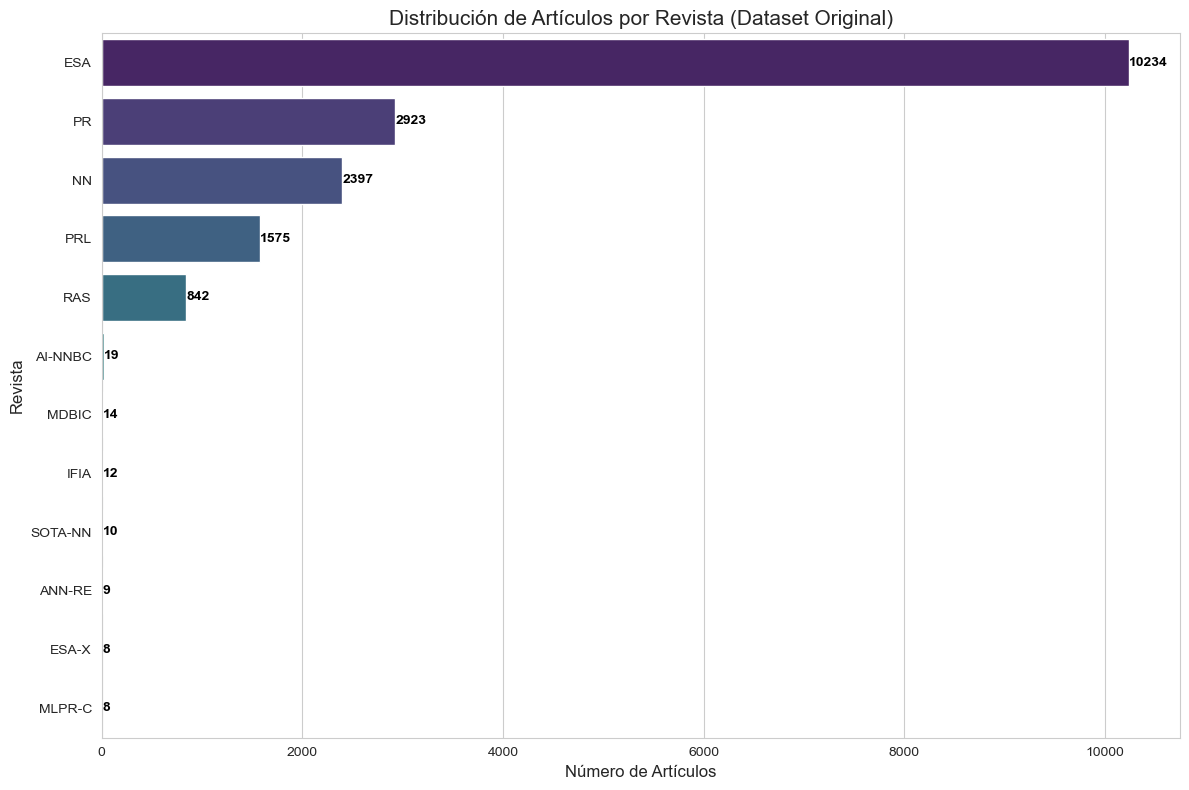

In [46]:
def plot_journal_distribution(journal_counts, tittle):

    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    sns.barplot(x=journal_counts.values, y=journal_counts.index, hue=journal_counts.index, palette='viridis', legend=False)

    plt.title(tittle, fontsize=15)
    plt.xlabel('Número de Artículos', fontsize=12)
    plt.ylabel('Revista', fontsize=12)

    for i, v in enumerate(journal_counts.values):
        plt.text(v + 3, i, str(v), color='black', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

journal_counts = df['journal'].value_counts()
plot_journal_distribution(journal_counts, "Distribución de Artículos por Revista (Dataset Original)")

### Problema de desbalanceo

Dada la naturaleza del corpus recolectado, se ha detectado un fuerte desequilibrio entre las categorías. Para evitar que el clasificador ignore las revistas con menor volumen de publicaciones, se ha aplicado un filtro de soporte mínimo. Esta decisión de diseño permite trabajar con un dataset más equilibrado y estadísticamente significativo, mejorando la fiabilidad de las recomendaciones finales.

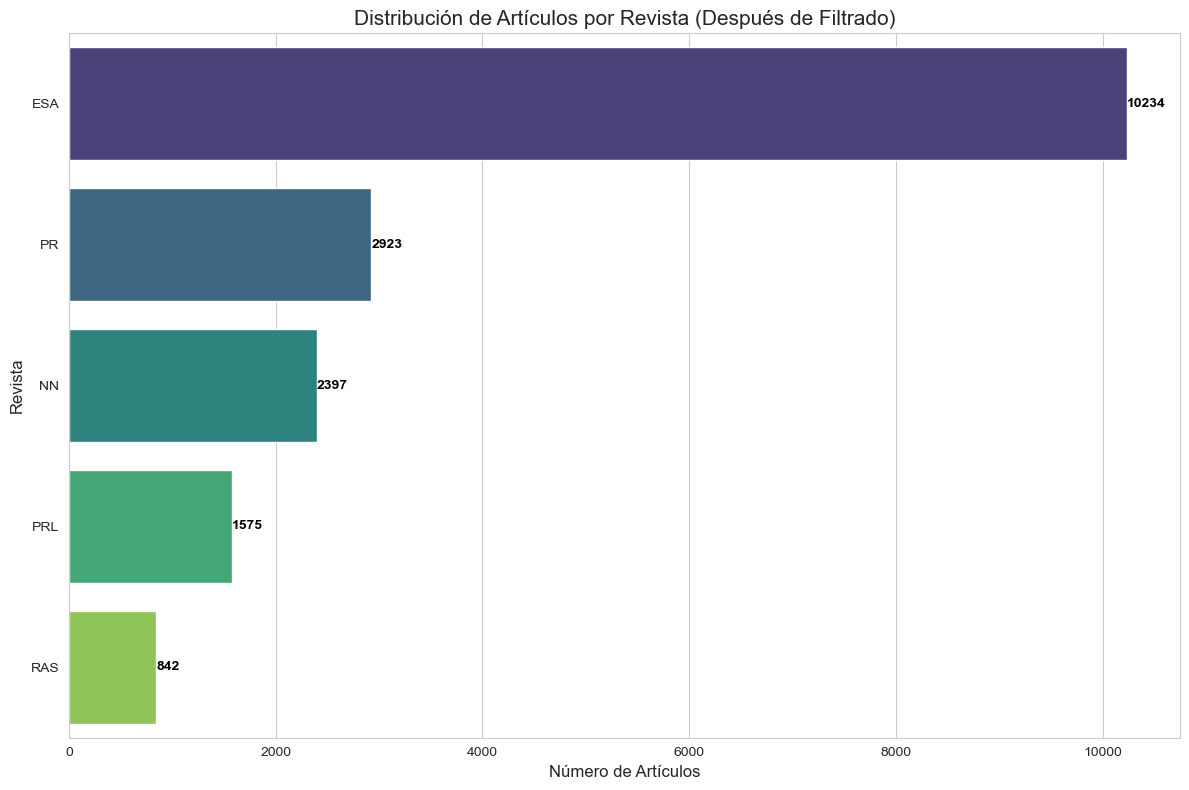

In [47]:
MIN_SAMPLES_PER_JOURNAL = 20
df = df[df['journal'].isin(journal_counts[journal_counts >= MIN_SAMPLES_PER_JOURNAL].index)]

plot_journal_distribution(df['journal'].value_counts(), "Distribución de Artículos por Revista (Después de Filtrado)")

### Exportar el dataset procesado como csv

In [18]:
os.makedirs("Data/processed", exist_ok=True)

df.to_csv("Data/processed/datatset_clean.csv", index=False)

## División del conjunto de datos

El conjunto de datos se divide en entrenamiento (80%) y test (20%) de forma estratificada por revista.
El conjunto de test se reserva exclusivamente para la evaluación final y no se utiliza durante el proceso de validación cruzada.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["journal"],
    test_size=0.2,
    random_state=42,
    stratify=df["journal"]
)

## Configuración de la validación cruzada

Para evaluar de forma robusta el rendimiento de los modelos se emplea validación cruzada estratificada de 5 particiones sobre el conjunto de entrenamiento, utilizando métricas macro para evitar sesgos debidos al desbalanceo entre revistas.

In [20]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "recall": "recall_macro",
    "f1": "f1_macro"
}

In [21]:
def print_cv_results(results, model_name):
    print(f"\n===== {model_name} (Cross-Validation) =====")
    for key in results:
        if key.startswith("test_"):
            values = results[key]
            metric = key.replace("test_", "")
            print(f"{metric}: {values.mean():.4f} ± {values.std():.4f}")

## Modelos usando TF-IDF

**TF-IDF (Term Frequency-Inverse Document Frequency)** es una técnica que convierte texto en números que los algoritmos de aprendizaje automático pueden procesar:

- **TF (Term Frequency):** Cuenta cuántas veces aparece cada palabra en un documento. Palabras frecuentes son más importantes.
- **IDF (Inverse Document Frequency):** Penaliza palabras que aparecen en muchos documentos (como "the", "and"). Palabras únicas a ciertos documentos son más valiosas.
- **Resultado:** Cada documento se representa como un vector numérico donde cada número refleja la importancia de una palabra en ese documento específico.

In [22]:
pipeline_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipeline_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

pipeline_rf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

### Validación cruzada de los modelos

In [23]:
results_lr = cross_validate(
    pipeline_lr, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)
results_svm = cross_validate(
    pipeline_svm, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)
results_rf = cross_validate(
    pipeline_rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
)

print_cv_results(results_lr, "Logistic Regression + TF-IDF")
print_cv_results(results_svm, "Linear SVM + TF-IDF")
print_cv_results(results_rf, "Random Forest + TF-IDF")


===== Logistic Regression + TF-IDF (Cross-Validation) =====
accuracy: 0.6789 ± 0.0096
precision: 0.5808 ± 0.0070
recall: 0.6384 ± 0.0107
f1: 0.6035 ± 0.0088

===== Linear SVM + TF-IDF (Cross-Validation) =====
accuracy: 0.7124 ± 0.0118
precision: 0.6097 ± 0.0125
recall: 0.6080 ± 0.0098
f1: 0.6063 ± 0.0113

===== Random Forest + TF-IDF (Cross-Validation) =====
accuracy: 0.6857 ± 0.0057
precision: 0.6842 ± 0.0189
recall: 0.4711 ± 0.0085
f1: 0.5069 ± 0.0097


## Modelos con lemmatización (NLTK) y TF-IDF

En esta variante se incorpora un preprocesado adicional basado en lematización con NLTK, con el objetivo de reducir la variabilidad morfológica de las palabras y evaluar su impacto en el rendimiento de los modelos.

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\santu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lematización de textos

La lematización reduce las palabras a su forma raíz (lema). Por ejemplo, "running", "runs" y "ran" se transforman todas en "run". 

Este proceso:
1. **Tokeniza** el texto en palabras individuales
2. **Lematiza** cada palabra a su forma base
3. **Filtra** stop words (palabras comunes sin significado: "the", "a", "is")
4. **Mantiene** solo palabras alfabéticas

El objetivo es reducir la variabilidad del lenguaje y mejorar el rendimiento del modelo al normalizar formas diferentes de la misma palabra.

In [25]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok.isalpha() and tok not in stop_words
    ]
    return " ".join(tokens)

X_train_lem = X_train.apply(lemmatize_text)
X_test_lem  = X_test.apply(lemmatize_text)

### Pipelines con lematización

In [26]:
pipeline_lr_lem = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

pipeline_svm_lem = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", LinearSVC(class_weight="balanced"))
])

pipeline_rf_lem = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=5
    )),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

### Validación cruzada con lematización

In [27]:
results_lr_lem = cross_validate(
    pipeline_lr_lem,
    X_train_lem,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

results_svm_lem = cross_validate(
    pipeline_svm_lem,
    X_train_lem,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

results_rf_lem = cross_validate(
    pipeline_rf_lem,
    X_train_lem,
    y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

print_cv_results(results_lr_lem, "Logistic Regression + Lemmatization")
print_cv_results(results_svm_lem, "Linear SVM + Lemmatization")
print_cv_results(results_rf_lem, "Random Forest + Lemmatization")


===== Logistic Regression + Lemmatization (Cross-Validation) =====
accuracy: 0.6761 ± 0.0091
precision: 0.5775 ± 0.0078
recall: 0.6352 ± 0.0101
f1: 0.6002 ± 0.0089

===== Linear SVM + Lemmatization (Cross-Validation) =====
accuracy: 0.7085 ± 0.0109
precision: 0.6040 ± 0.0112
recall: 0.6013 ± 0.0126
f1: 0.6000 ± 0.0120

===== Random Forest + Lemmatization (Cross-Validation) =====
accuracy: 0.6821 ± 0.0048
precision: 0.6979 ± 0.0198
recall: 0.4599 ± 0.0069
f1: 0.4949 ± 0.0074


# Entrenamiento final del modelo y evaluación en test

En esta fase, cada modelo se entrena utilizando la totalidad del conjunto de entrenamiento, sin validación cruzada, con el objetivo de maximizar la información disponible antes de la evaluación final.

## Sin lematización

In [28]:
pipeline_lr.fit(X_train, y_train)
pipeline_svm.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

print("Modelos entrenados.")

Modelos entrenados.


## Con lematización

In [29]:
pipeline_lr_lem.fit(X_train_lem, y_train)
pipeline_svm_lem.fit(X_train_lem, y_train)
pipeline_rf_lem.fit(X_train_lem, y_train)

print("Modelos entrenados.")

Modelos entrenados.


## Evaluación final en test

In [30]:
def evaluate_on_test(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"\n===== {model_name} - Test =====\n")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return y_pred

### Logistic Regression (sin lematización)

In [31]:
y_pred_lr = evaluate_on_test(
    pipeline_lr,
    X_test,
    y_test,
    "Logistic Regression (TF-IDF)"
)


===== Logistic Regression (TF-IDF) - Test =====

Accuracy: 0.6845618915159944
Classification Report:
              precision    recall  f1-score   support

         ESA       0.90      0.75      0.82      2047
          NN       0.57      0.65      0.61       480
          PR       0.49      0.61      0.54       585
         PRL       0.28      0.37      0.32       315
         RAS       0.70      0.85      0.77       168

    accuracy                           0.68      3595
   macro avg       0.59      0.64      0.61      3595
weighted avg       0.72      0.68      0.70      3595



### Linear SVM (sin lematización)

In [32]:
y_pred_svm = evaluate_on_test(
    pipeline_svm,
    X_test,
    y_test,
    "Linear SVM (TF-IDF)"
)


===== Linear SVM (TF-IDF) - Test =====

Accuracy: 0.7159944367176634
Classification Report:
              precision    recall  f1-score   support

         ESA       0.86      0.85      0.85      2047
          NN       0.59      0.58      0.59       480
          PR       0.51      0.59      0.55       585
         PRL       0.34      0.27      0.30       315
         RAS       0.76      0.81      0.78       168

    accuracy                           0.72      3595
   macro avg       0.61      0.62      0.61      3595
weighted avg       0.71      0.72      0.71      3595



### Random Forest (sin lematización)

In [33]:
y_pred_rf = evaluate_on_test(
    pipeline_rf,
    X_test,
    y_test,
    "Random Forest (TF-IDF)"
)


===== Random Forest (TF-IDF) - Test =====

Accuracy: 0.6812239221140473
Classification Report:
              precision    recall  f1-score   support

         ESA       0.69      0.94      0.80      2047
          NN       0.86      0.34      0.48       480
          PR       0.52      0.44      0.47       585
         PRL       0.65      0.05      0.09       315
         RAS       0.78      0.55      0.64       168

    accuracy                           0.68      3595
   macro avg       0.70      0.46      0.50      3595
weighted avg       0.69      0.68      0.63      3595



### Logistic Regression (con lematización)

In [34]:
y_pred_lr_lem = evaluate_on_test(
    pipeline_lr_lem,
    X_test_lem,
    y_test,
    "Logistic Regression (Lemmatization)"
)


===== Logistic Regression (Lemmatization) - Test =====

Accuracy: 0.6828929068150209
Classification Report:
              precision    recall  f1-score   support

         ESA       0.90      0.75      0.82      2047
          NN       0.55      0.64      0.60       480
          PR       0.48      0.62      0.54       585
         PRL       0.29      0.35      0.31       315
         RAS       0.70      0.85      0.77       168

    accuracy                           0.68      3595
   macro avg       0.58      0.64      0.61      3595
weighted avg       0.72      0.68      0.70      3595



### Linear SVM (con lematización)

In [35]:
y_pred_svm_lem = evaluate_on_test(
    pipeline_svm_lem,
    X_test_lem,
    y_test,
    "Linear SVM (Lemmatization)"
)


===== Linear SVM (Lemmatization) - Test =====

Accuracy: 0.7112656467315717
Classification Report:
              precision    recall  f1-score   support

         ESA       0.85      0.84      0.84      2047
          NN       0.59      0.56      0.58       480
          PR       0.51      0.59      0.55       585
         PRL       0.33      0.25      0.28       315
         RAS       0.76      0.82      0.79       168

    accuracy                           0.71      3595
   macro avg       0.61      0.61      0.61      3595
weighted avg       0.71      0.71      0.71      3595



### Random Forest (con lematización)

In [36]:
y_pred_rf_lem = evaluate_on_test(
    pipeline_rf_lem,
    X_test_lem,
    y_test,
    "Random Forest (Lemmatization)"
)


===== Random Forest (Lemmatization) - Test =====

Accuracy: 0.678442280945758
Classification Report:
              precision    recall  f1-score   support

         ESA       0.69      0.94      0.80      2047
          NN       0.89      0.33      0.48       480
          PR       0.50      0.44      0.47       585
         PRL       0.69      0.03      0.07       315
         RAS       0.81      0.50      0.62       168

    accuracy                           0.68      3595
   macro avg       0.72      0.45      0.49      3595
weighted avg       0.69      0.68      0.63      3595



## Matriz de confusión del mejor modelo (Linear SVM)

In [25]:
def plot_confusion_matrix(y_true, y_pred, labels, title,figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
        cmap="Blues"
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Matriz de confusión — Mejor modelo sin lematización

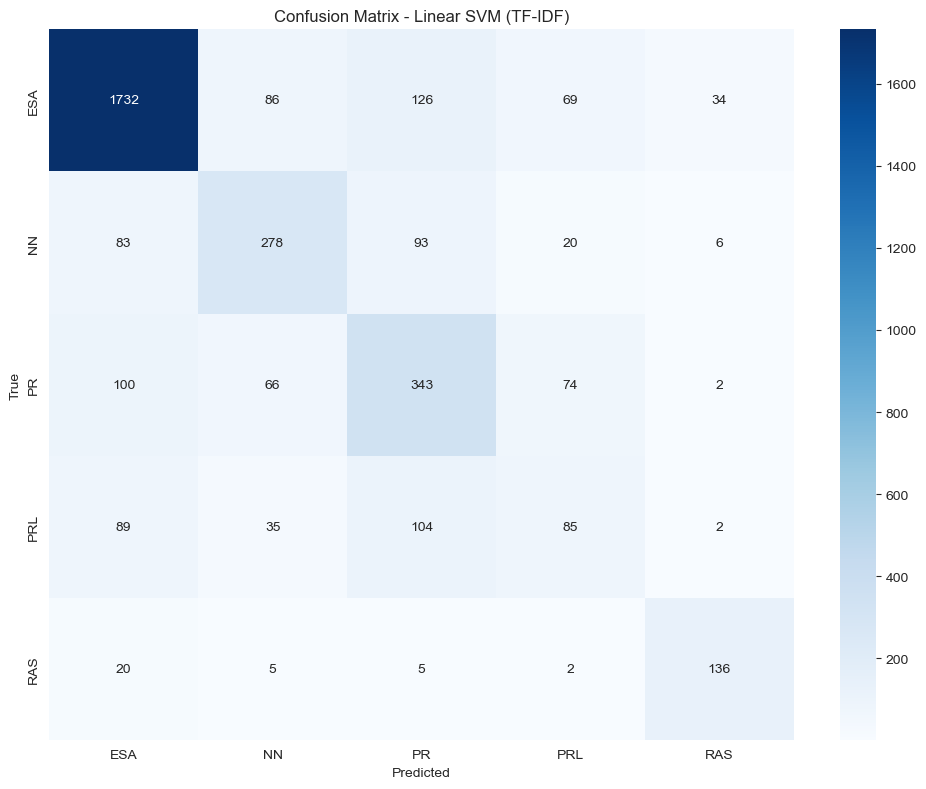

In [38]:
labels = sorted(df["journal"].unique())
plot_confusion_matrix(
    y_test,
    y_pred_svm,
    labels,
    "Confusion Matrix - Linear SVM (TF-IDF)"
)

### Matriz de confusión — Mejor modelo con lematización

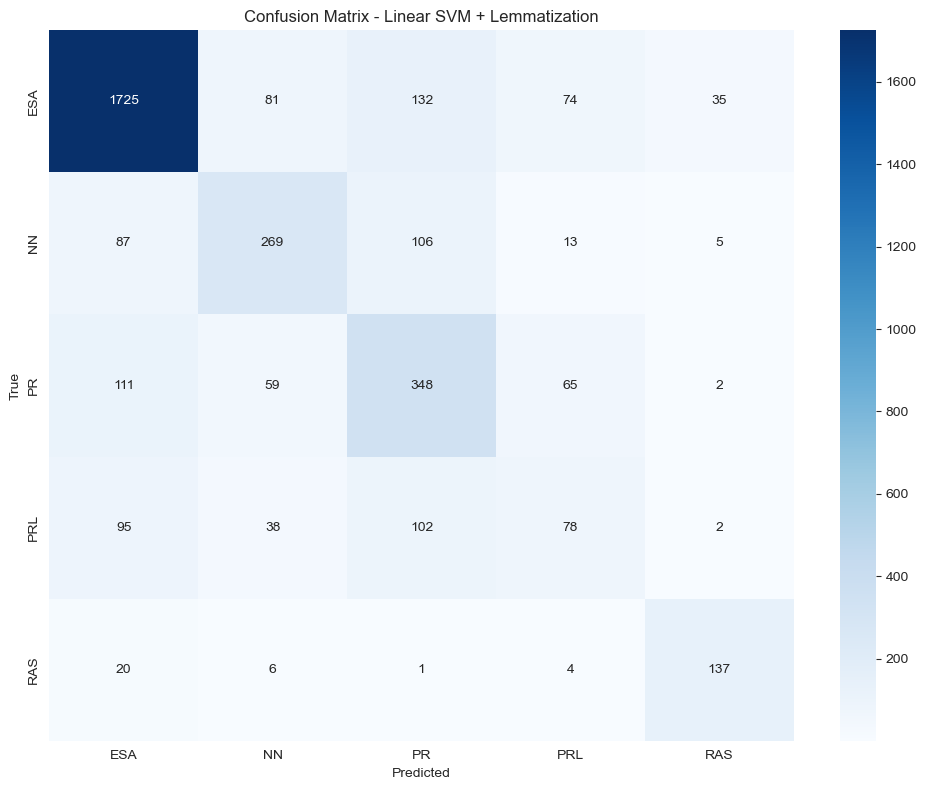

In [39]:
plot_confusion_matrix(
    y_test,
    y_pred_svm_lem,
    labels,
    "Confusion Matrix - Linear SVM + Lemmatization"
)

# Aproximación Conexionista

En esta segunda aproximación se exploran técnicas de Deep Learning para abordar el mismo problema de recomendación de revistas, con el objetivo de comparar su rendimiento frente a los métodos clásicos y evaluar si la mayor complejidad del modelo se traduce en mejoras significativas.

**Metodología:**

1. **Representación semántica del texto**: En lugar de TF-IDF, se utilizan Word2Vec embeddings entrenados específicamente sobre el corpus de artículos. Esta técnica captura relaciones semánticas entre palabras y preserva el contexto en el que aparecen.

2. **Arquitectura BiLSTM**: Se implementa una red neuronal Bidirectional LSTM (Long Short-Term Memory) que:
   - Procesa las secuencias de palabras en ambas direcciones (adelante y atrás)
   - Captura dependencias a largo plazo en el texto
   - Modela el orden y el contexto de las palabras, a diferencia de TF-IDF

3. **Regularización y control del sobreajuste**: Dado que las redes neuronales tienden a memorizar los datos de entrenamiento, se aplican técnicas como:
   - **Dropout**: Desactiva aleatoriamente neuronas durante el entrenamiento
   - **Weight Decay (L2)**: Penaliza pesos grandes para evitar sobreajuste
   - **Early Stopping**: Detiene el entrenamiento cuando el rendimiento en validación deja de mejorar

4. **Entrenamiento con PyTorch**: Se utiliza el framework PyTorch para construir y entrenar el modelo, aprovechando GPU si está disponible para acelerar el proceso.

Esta aproximación representa un paradigma diferente: en lugar de características diseñadas manualmente (TF-IDF), la red neuronal aprende qué características son relevantes para la clasificación a partir de los embeddings.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
import re

## Comprobar si hay una GPU disponible

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU detectada:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Usando CPU")

GPU detectada: NVIDIA GeForce RTX 4070 SUPER


## Tokenizador sencillo para preparar el texto para Word2Vec

Esta celda implementa un **tokenizador básico** que prepara los textos para entrenar el modelo Word2Vec:

**Proceso de tokenización:**

1. **Normalización a minúsculas**: Asegura que "Neural" y "neural" se traten como la misma palabra
2. **Limpieza de caracteres especiales**: La expresión regular `[^a-z0-9\s]` elimina todo excepto letras, números y espacios (signos de puntuación, símbolos, etc.)
3. **División en tokens**: `split()` convierte el texto limpio en una lista de palabras individuales

**Ejemplo de transformación:**
- **Entrada**: "Deep Learning: A Survey on Neural Networks!"
- **Salida**: `["deep", "learning", "a", "survey", "on", "neural", "networks"]`

Este preprocesamiento es más simple que la lematización usada anteriormente (no elimina stopwords ni reduce palabras a su raíz), lo cual es apropiado para Word2Vec ya que el modelo aprende mejor con contextos completos.

In [5]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

df = pd.read_csv("Data/processed/datatset_clean.csv")

sentences = [tokenize(t) for t in df["text"]]

## Uso de Word2Vec

**Word2Vec** es un algoritmo de aprendizaje no supervisado que aprende representaciones vectoriales (embeddings) de palabras capturando su significado semántico. Palabras con significados similares tienen vectores cercanos en el espacio vectorial.

**¿Cómo funciona?**
- Analiza el contexto en el que aparecen las palabras en grandes corpus de texto
- Aprende que palabras como "neural" y "network" aparecen frecuentemente juntas
- Genera vectores numéricos donde la distancia entre vectores refleja similitud semántica

**Parámetros del modelo:**

- **`sentences`**: Lista de documentos tokenizados (cada documento es una lista de palabras)
- **`vector_size=100`**: Dimensión de los vectores de embeddings (cada palabra se representa con 100 números)
- **`window=5`**: Ventana de contexto - considera 5 palabras antes y después para aprender relaciones
- **`min_count=2`**: Ignora palabras que aparecen menos de 2 veces (elimina palabras muy raras)
- **`workers=4`**: Número de hilos de CPU para entrenar en paralelo
- **`sg=1`**: Usa Skip-gram (predice palabras de contexto dado una palabra central)

In [6]:
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

os.makedirs("Models/word2vec", exist_ok=True)
w2v_model.save("Models/word2vec/w2v.model")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

## Construcción de la matriz de embeddings

### Construcción del vocabulario y mapeo palabra-índice

En esta celda se construye un diccionario de vocabulario que mapea cada palabra a un índice numérico único. Este diccionario es esencial para convertir textos en secuencias numéricas que la red neuronal pueda procesar.

**Proceso:**

1. **Carga del modelo Word2Vec**: Se recupera el modelo entrenado anteriormente que contiene los embeddings de las palabras

2. **Tokens especiales**: Se añaden dos tokens especiales al inicio del vocabulario:
   - `<pad>` (índice 0): Utilizado para rellenar secuencias cortas hasta la longitud máxima
   - `<unk>` (índice 1): Representa palabras desconocidas que no están en el vocabulario

3. **Asignación de índices**: Cada palabra del modelo Word2Vec recibe un índice único secuencial (2, 3, 4, ...)

**Resultado:**

Un diccionario donde las claves son palabras y los valores son índices numéricos. Por ejemplo:
```python
{"<pad>": 0, "<unk>": 1, "neural": 2, "network": 3, "learning": 4, ...}
```

Este vocabulario permite transformar la frase "neural network" en la secuencia numérica `[2, 3]`, que posteriormente se puede buscar en la matriz de embeddings para obtener las representaciones vectoriales.

In [7]:
w2v_model = Word2Vec.load("Models/word2vec/w2v.model")

vocab = {"<pad>":0, "<unk>":1}
for word in w2v_model.wv.index_to_key:
    vocab[word] = len(vocab)

### Creación de la matriz de embeddings para la red neuronal

En esta celda se construye la matriz de embeddings que servirá como capa de entrada de la red neuronal BiLSTM. Esta matriz es una tabla de consulta donde cada fila corresponde a una palabra del vocabulario y contiene su representación vectorial.

**Proceso:**

1. **Inicialización de la matriz**: Se crea una matriz de ceros con dimensiones `(tamaño_vocabulario × dimensión_embedding)`. En este caso, será de tamaño `(vocabulario × 100)`.

2. **Llenado de vectores desde Word2Vec**: Para cada palabra del vocabulario:
   - Si la palabra existe en el modelo Word2Vec (palabras del corpus), se copia su vector pre-entrenado
   - Si no existe (tokens especiales `<pad>` y `<unk>`), se genera un vector aleatorio con distribución normal

3. **Conversión a tensor de PyTorch**: La matriz NumPy se convierte en un tensor para que pueda ser utilizado por la red neuronal.

**Resultado:**

Una matriz donde cada fila es un embedding de 100 dimensiones. Por ejemplo:
```python
embedding_matrix[0]  # Vector para <pad> (aleatorio)
embedding_matrix[1]  # Vector para <unk> (aleatorio)
embedding_matrix[2]  # Vector para "neural" (desde Word2Vec)
embedding_matrix[3]  # Vector para "network" (desde Word2Vec)
```

Esta matriz se utilizará en la capa de embedding de la red neuronal: cuando el modelo recibe la secuencia `[2, 3]` (neural network), buscará las filas 2 y 3 de esta matriz para obtener las representaciones vectoriales correspondientes.

In [8]:
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for word, idx in vocab.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

## Arquitectura de la red neuronal BiLSTM

En esta celda se define la arquitectura de la red neuronal BiLSTM para la clasificación de artículos en revistas. Esta clase encapsula todas las capas y la lógica de propagación del modelo.

**Componentes de la arquitectura:**

1. **Capa de Embedding** (`nn.Embedding.from_pretrained`):
   - Carga la matriz de embeddings pre-entrenada con Word2Vec
   - Convierte índices de palabras en vectores densos de 100 dimensiones
   - `freeze_embeddings=False`: Permite ajustar los embeddings durante el entrenamiento
   - `padding_idx=0`: Indica que el índice 0 (`<pad>`) debe ignorarse en el cálculo de gradientes

2. **Capa Dropout** (50%):
   - Desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento
   - Previene el sobreajuste forzando al modelo a no depender de características específicas

3. **Capa BiLSTM** (`nn.LSTM` con `bidirectional=True`):
   - Procesa las secuencias de embeddings en ambas direcciones (adelante y atrás)
   - `hidden_dim=64`: Cada dirección tiene 64 unidades ocultas
   - Captura dependencias contextuales a largo plazo en el texto
   - El output final concatena ambas direcciones (128 dimensiones totales)

4. **Capa de Clasificación** (`nn.Linear`):
   - Transforma la representación final (128 dim) en logits para cada clase
   - `num_classes`: Número de revistas posibles (salida del modelo)

**Flujo de propagación (método `forward`):**

```
Texto → Embeddings → Dropout → BiLSTM → Concatenar estados finales → Dropout → Clasificación
```

El estado final del LSTM (última celda en ambas direcciones) captura la representación completa del documento, que luego se clasifica en una de las revistas.

In [9]:
class BiLSTMJournalClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes, freeze_embeddings=False):
        super().__init__()

        vocab_size, embed_dim = embedding_matrix.shape

        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix,
            freeze=freeze_embeddings,
            padding_idx=0
        )

        self.dropout = nn.Dropout(0.5)

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        emb = self.dropout(emb)

        _, (h_n, _) = self.lstm(emb)

        h_fw = h_n[0]
        h_bw = h_n[1]
        h = torch.cat((h_fw, h_bw), dim=1)

        h = self.dropout(h)

        return self.fc(h)


### Preparación de los datos para entrenamiento con PyTorch

En esta sección se realiza la transformación de los datos textuales en estructuras compatibles con PyTorch, necesarias para entrenar la red neuronal BiLSTM. Este proceso involucra varios pasos críticos:

**1. Codificación de etiquetas:**
- Se extraen las revistas únicas del dataset y se ordenan alfabéticamente
- Se crean dos diccionarios de mapeo:
  - `label2idx`: Convierte nombres de revistas a índices numéricos (ej: "NN" → 0, "ESA" → 1)
  - `idx2label`: Conversión inversa para interpretar las predicciones del modelo

**2. División estratificada del dataset:**
- Se separa el dataset en conjuntos de entrenamiento (80%) y test (20%)
- La división es estratificada: mantiene la proporción de cada revista en ambos conjuntos
- Garantiza una evaluación justa del modelo en todas las clases

**3. Función de codificación de texto (`encode_text`):**
- Tokeniza cada documento y convierte palabras en índices usando el vocabulario
- Limita las secuencias a una longitud máxima (`max_len`)
- Rellena secuencias cortas con tokens `<pad>` para que todas tengan la misma longitud
- Palabras desconocidas se reemplazan por el índice de `<unk>`

**4. Dataset personalizado (`JournalDataset`):**
- Clase que hereda de `torch.utils.data.Dataset`
- Encapsula la lógica de acceso a los datos: dado un índice, devuelve un par (texto_codificado, etiqueta_codificada)
- Permite la iteración eficiente durante el entrenamiento

**5. DataLoaders:**
- `train_loader`: Itera sobre el conjunto de entrenamiento en lotes de 32 muestras con orden aleatorio
- `val_loader`: Itera sobre el conjunto de test en lotes de 32 muestras sin mezclar (para evaluación determinista)
- Facilitan el procesamiento por lotes (batching), esencial para aprovechar la GPU y estabilizar el entrenamiento

**Resultado:**
Los datos quedan listos para ser consumidos por el modelo durante el ciclo de entrenamiento, con todas las transformaciones necesarias (tokenización, padding, codificación) encapsuladas en los DataLoaders.

In [35]:
texts = df["text"].tolist()
labels = df["journal"].tolist()

unique_labels = sorted(set(labels))
label2idx = {label: i for i, label in enumerate(unique_labels)}
idx2label = {i: label for label, i in label2idx.items()}

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [12]:
def encode_text(text, vocab, max_len):
    tokens = tokenize(text)
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens[:max_len]]
    return ids + [vocab["<pad>"]] * (max_len - len(ids))

In [13]:
class JournalDataset(Dataset):
    def __init__(self, texts, labels, vocab, label2idx, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.label2idx = label2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = encode_text(self.texts[idx], self.vocab, self.max_len)
        y = self.label2idx[self.labels[idx]]
        return torch.tensor(x), torch.tensor(y)

In [14]:
MAX_LEN = 300
BATCH_SIZE = 32

train_dataset = JournalDataset(X_train, y_train, vocab, label2idx, MAX_LEN)
test_dataset  = JournalDataset(X_test,  y_test,  vocab, label2idx, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Entrenamiento

## Funciones auxiliares para el entrenamiento

En esta celda se definen tres funciones auxiliares que encapsulan la lógica de entrenamiento y evaluación de la red neuronal BiLSTM. Estas funciones facilitan la implementación del bucle de entrenamiento y permiten reutilizar código de forma modular.

**1. `train_one_epoch(model, loader, optimizer, criterion, device)`**

Ejecuta una época completa de entrenamiento sobre el conjunto de entrenamiento:

- **Modo entrenamiento**: Activa `model.train()` para habilitar Dropout y actualización de gradientes
- **Iteración por lotes**: Recorre todos los batches del `train_loader`
- **Propagación hacia adelante**: Calcula las predicciones del modelo (`outputs = model(x)`)
- **Cálculo de pérdida**: Evalúa la función de coste (CrossEntropyLoss) entre predicciones y etiquetas reales
- **Retropropagación**: Calcula gradientes con `loss.backward()` y actualiza pesos con `optimizer.step()`
- **Métricas**: Acumula pérdida promedio y accuracy del entrenamiento
- **Retorno**: Devuelve la pérdida promedio y accuracy de la época

**2. `evaluate_one_epoch(model, loader, criterion, device)`**

Evalúa el modelo en el conjunto de validación/test sin actualizar pesos:

- **Modo evaluación**: Activa `model.eval()` para desactivar Dropout y normalización
- **Sin gradientes**: Usa `torch.no_grad()` para ahorrar memoria y acelerar cómputo (no se necesitan gradientes para evaluación)
- **Propagación hacia adelante**: Calcula predicciones sin backpropagation
- **Métricas**: Calcula pérdida y accuracy en el conjunto de validación
- **Retorno**: Devuelve la pérdida promedio y accuracy de validación

Esta función permite monitorizar el rendimiento del modelo durante el entrenamiento para detectar sobreajuste (si la accuracy de entrenamiento sube pero la de validación baja).

**3. `evaluate_final(model, loader, device)`**

Realiza la evaluación final del modelo guardando todas las predicciones:

- **Modo evaluación**: Similar a `evaluate_one_epoch`, pero sin calcular pérdida
- **Recopilación de predicciones**: Almacena las etiquetas verdaderas (`y_true`) y las predicciones (`y_pred`) para cada muestra
- **Retorno**: Devuelve listas completas de etiquetas reales y predichas

Esta función se utiliza al final del entrenamiento para generar métricas detalladas (classification report, matriz de confusión) y analizar el rendimiento del modelo en profundidad.

In [15]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate_final(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

## Configuración e instanciación del modelo BiLSTM y entrenamiento

En esta sección se configura y entrena el modelo BiLSTM completo. El proceso se divide en dos etapas principales:

### 1. Instanciación del modelo y configuración de componentes

**Creación del modelo:**
- Se instancia la clase `BiLSTMJournalClassifier` con los parámetros definidos:
  - `embedding_matrix`: Matriz de embeddings pre-entrenada con Word2Vec
  - `hidden_dim=64`: 64 unidades ocultas por dirección en el LSTM (128 totales al ser bidireccional)
  - `num_classes`: Número de revistas (clases de salida)
  - `freeze_embeddings=False`: Permite ajustar los embeddings durante el entrenamiento
- Se transfiere el modelo al dispositivo adecuado (GPU si está disponible, CPU en caso contrario)

**Función de pérdida (criterion):**
- `CrossEntropyLoss`: Función de coste estándar para clasificación multiclase
- Combina LogSoftmax y NLLLoss en una única operación eficiente
- Penaliza las predicciones incorrectas proporcionalmente a su confianza errónea

**Optimizador:**
- `Adam`: Algoritmo de optimización adaptativo que ajusta la tasa de aprendizaje por parámetro
- `lr=1e-3`: Tasa de aprendizaje inicial (0.001)
- `weight_decay=1e-5`: Regularización L2 para penalizar pesos grandes y prevenir sobreajuste

### 2. Bucle de entrenamiento con Early Stopping

**Hiperparámetros:**
- `EPOCHS=100`: Número máximo de épocas de entrenamiento
- `EARLY_STOP_PATIENCE=10`: Si la accuracy de validación no mejora durante 10 épocas consecutivas, se detiene el entrenamiento

**Proceso por época:**
1. **Entrenamiento**: Se llama a `train_one_epoch()` que:
   - Procesa todos los batches del conjunto de entrenamiento
   - Actualiza los pesos del modelo mediante backpropagation
   - Calcula pérdida y accuracy de entrenamiento

2. **Validación**: Se llama a `evaluate_one_epoch()` que:
   - Evalúa el modelo en el conjunto de validación sin actualizar pesos
   - Calcula pérdida y accuracy de validación para monitorizar el rendimiento

3. **Registro de métricas**: Se almacenan las métricas de cada época en listas para posterior análisis y visualización

4. **Early Stopping**: Mecanismo de control del sobreajuste:
   - Si la accuracy de validación mejora: se guarda el modelo y se reinicia el contador de paciencia
   - Si no mejora: se incrementa el contador de paciencia
   - Si el contador alcanza 10 épocas sin mejora: se detiene el entrenamiento para evitar sobreajuste

**Resultado:**
Al finalizar el entrenamiento, se habrá guardado el modelo con mejor rendimiento en validación en el archivo `Models/BiLSTM_best_model/best_model.pth`, y se dispondrá del historial completo de pérdidas y accuracies para analizar la evolución del entrenamiento.

In [16]:
model = BiLSTMJournalClassifier(
    embedding_matrix=embedding_tensor,
    hidden_dim=64,
    num_classes=len(label2idx),
    freeze_embeddings=False
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [17]:
EPOCHS = 100
EARLY_STOP_PATIENCE = 10

best_val_acc = 0.0
patience_counter = 0

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate_one_epoch(
        model, val_loader, criterion, device
    )

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        os.makedirs("Models/BiLSTM_best_model", exist_ok=True)
        torch.save(model.state_dict(), f"Models/BiLSTM_best_model/best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print("Early stopping triggered")
            break


Epoch 01/100 | Train Loss: 1.1004 | Train Acc: 0.5860 | Val Loss: 0.9632 | Val Acc: 0.6242
Epoch 02/100 | Train Loss: 0.9133 | Train Acc: 0.6519 | Val Loss: 0.8226 | Val Acc: 0.6818
Epoch 03/100 | Train Loss: 0.7954 | Train Acc: 0.6998 | Val Loss: 0.8071 | Val Acc: 0.6921
Epoch 04/100 | Train Loss: 0.7159 | Train Acc: 0.7304 | Val Loss: 0.7767 | Val Acc: 0.7051
Epoch 05/100 | Train Loss: 0.6392 | Train Acc: 0.7602 | Val Loss: 0.8010 | Val Acc: 0.7038
Epoch 06/100 | Train Loss: 0.5498 | Train Acc: 0.7962 | Val Loss: 0.8647 | Val Acc: 0.7040
Epoch 07/100 | Train Loss: 0.4410 | Train Acc: 0.8413 | Val Loss: 1.1058 | Val Acc: 0.6776
Epoch 08/100 | Train Loss: 0.3300 | Train Acc: 0.8813 | Val Loss: 1.0726 | Val Acc: 0.6854
Epoch 09/100 | Train Loss: 0.2331 | Train Acc: 0.9201 | Val Loss: 1.2644 | Val Acc: 0.6759
Epoch 10/100 | Train Loss: 0.1629 | Train Acc: 0.9481 | Val Loss: 1.6128 | Val Acc: 0.6339
Epoch 11/100 | Train Loss: 0.1069 | Train Acc: 0.9664 | Val Loss: 1.5892 | Val Acc: 0.6456

## Carga del mejor modelo y evaluación exhaustiva de su rendimiento

En esta sección se recupera el modelo BiLSTM con mejor rendimiento en validación y se realiza un análisis completo de su desempeño.

### 1. Carga del modelo óptimo

**Recuperación del estado guardado:**
- Se utiliza `torch.load()` para cargar los pesos del modelo desde el archivo `best_model.pth`
- El parámetro `weights_only=True` garantiza seguridad al cargar solo los pesos
- Se aplican estos pesos al modelo mediante `load_state_dict()`
- El modelo se transfiere al dispositivo correcto (GPU/CPU) para la evaluación

**Justificación:**
Durante el entrenamiento, el modelo puede seguir aprendiendo después de alcanzar su mejor rendimiento en validación (sobreajuste). Al guardar el checkpoint con mejor accuracy de validación, nos aseguramos de evaluar el modelo en su punto óptimo de generalización, no en su estado final de entrenamiento.

### 2. Visualización del historial de entrenamiento

**Gráficas de pérdida y accuracy:**
- Se generan dos gráficas que muestran la evolución de las métricas a lo largo de las épocas:
  - **Pérdida (Loss)**: Permite identificar si el modelo converge correctamente y detectar divergencias
  - **Accuracy**: Muestra la tasa de acierto en entrenamiento y validación

**Análisis de las curvas:**
- **Curvas convergentes**: Train y validation loss disminuyen juntas → modelo generaliza bien
- **Divergencia de curvas**: Train loss baja pero validation loss sube → señal de sobreajuste
- **Diferencia notable entre train y validation accuracy**: Diferencia persistente indica sobreajuste (el modelo memoriza datos de entrenamiento)

Estas visualizaciones son cruciales para diagnosticar problemas de aprendizaje y justificar decisiones sobre regularización y early stopping.

### 3. Evaluación final en el conjunto de test

**Métricas de rendimiento:**
- Se ejecuta `evaluate_final()` que genera predicciones para todo el conjunto de test
- Se calcula la **accuracy global** como métrica principal de rendimiento
- Se genera un **classification report** detallado que incluye por cada revista:
  - **Precision**: De los artículos predichos como revista X, ¿cuántos realmente pertenecen a X?
  - **Recall**: De los artículos reales de revista X, ¿cuántos fueron correctamente identificados?
  - **F1-score**: Media armónica de precision y recall (equilibrio entre ambas)
  - **Support**: Número de artículos reales de cada revista

Este reporte permite identificar qué revistas se clasifican mejor y cuáles presentan mayor confusión.

### 4. Matriz de confusión

**Visualización de errores de clasificación:**
- La matriz de confusión muestra la distribución completa de predicciones:
  - **Diagonal**: Predicciones correctas (valores altos indican buen rendimiento)
  - **Fuera de diagonal**: Confusiones entre revistas (errores de clasificación)

**Interpretación:**
- Valores altos fuera de la diagonal entre dos revistas indican confusión sistemática
- Permite identificar revistas temáticamente similares que el modelo confunde
- Facilita el análisis de errores y posibles mejoras

**Resultado final:**
Esta sección proporciona una evaluación completa y transparente del modelo, permitiendo no solo conocer su rendimiento global sino también entender sus fortalezas, debilidades y patrones de error específicos por revista.

In [19]:
model.load_state_dict(torch.load("Models/BiLSTM_best_model/best_model.pth", weights_only=True))
model.to(device)

BiLSTMJournalClassifier(
  (embedding): Embedding(44465, 100, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

### Evolución de la pérdida y accuracy por época

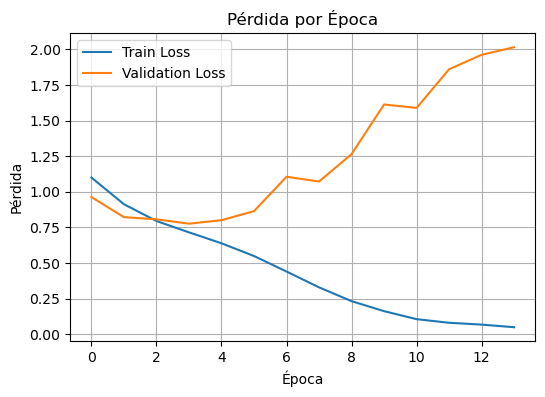

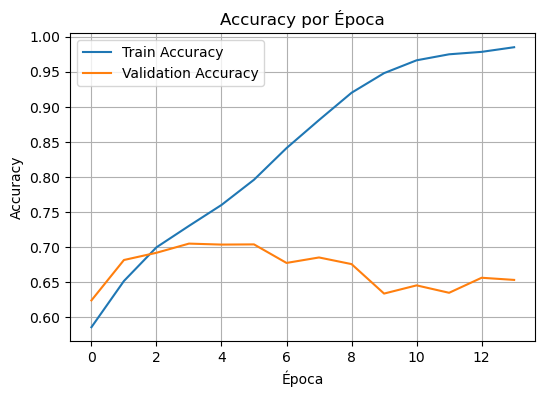

In [23]:
def plot_model_performance(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    plt.figure(figsize=(6,4))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.title("Pérdida por Época")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(train_acc_history, label="Train Accuracy")
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.xlabel("Época")
    plt.ylabel("Accuracy")
    plt.title("Accuracy por Época")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_model_performance(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

### Evaluación final en test

In [28]:
y_true, y_pred = evaluate_final(model, val_loader, device)

print("Final Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(
    y_true,
    y_pred,
    target_names=[idx2label[i] for i in range(len(idx2label))]
))

Final Test Accuracy: 0.7051460361613352
              precision    recall  f1-score   support

         ESA       0.79      0.89      0.83      2047
          NN       0.64      0.49      0.56       480
          PR       0.49      0.60      0.54       585
         PRL       0.43      0.09      0.15       315
         RAS       0.78      0.64      0.70       168

    accuracy                           0.71      3595
   macro avg       0.63      0.54      0.56      3595
weighted avg       0.69      0.71      0.68      3595



### Matriz de confusión

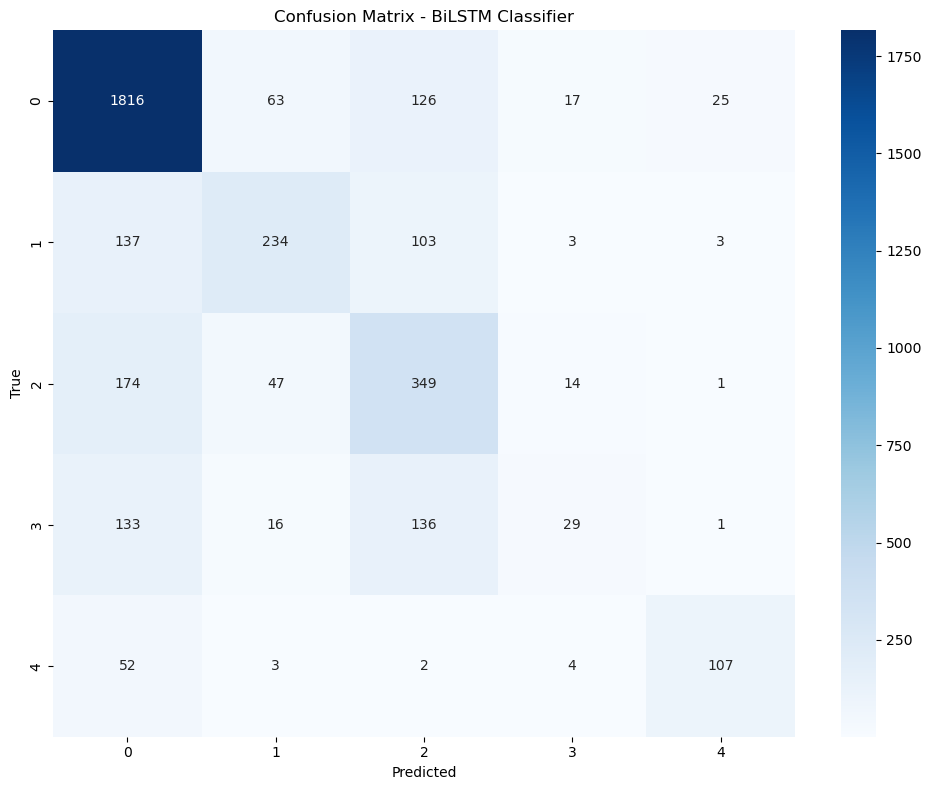

In [39]:
labels = list(range(len(idx2label)))

plot_confusion_matrix(y_true, y_pred, labels, "Confusion Matrix - BiLSTM Classifier")

# Conclusiones generales

En este trabajo se ha abordado el problema de la recomendación automática de revistas científicas a partir del título, resumen y palabras clave de un artículo, utilizando técnicas de Procesamiento del Lenguaje Natural y modelos de clasificación. Para ello, se han explorado dos aproximaciones diferenciadas: una aproximación clásica basada en representaciones TF-IDF y clasificadores tradicionales, y una aproximación conexionista basada en redes neuronales recurrentes.

En la primera parte del trabajo, se han aplicado técnicas de preprocesamiento estándar y se ha representado el texto mediante TF-IDF, entrenando distintos modelos de clasificación como Regresión Logística, Linear SVM y Random Forest. Los resultados obtenidos muestran que el modelo Linear SVM alcanza el mejor rendimiento global, con una precisión cercana al 72%, superando al resto de modelos tanto en validación cruzada como en el conjunto de test. El análisis mediante matrices de confusión ha permitido identificar confusiones recurrentes entre revistas temáticamente cercanas, como Neural Networks, Pattern Recognition y Pattern Recognition Letters, lo cual resulta coherente desde un punto de vista semántico.

En la segunda parte del trabajo se ha implementado una aproximación conexionista basada en una arquitectura BiLSTM, utilizando embeddings Word2Vec entrenados específicamente sobre el corpus de artículos. Este modelo presenta una elevada capacidad de representación, alcanzando rápidamente altos valores de precisión en el conjunto de entrenamiento. No obstante, también se ha observado un claro fenómeno de sobreajuste, mitigado mediante la incorporación de técnicas de regularización como Dropout, regularización L2 (weight decay) y early stopping. A pesar de estas medidas, el rendimiento final del modelo BiLSTM resulta comparable, pero no claramente superior, al obtenido con los modelos clásicos.

La comparación entre ambas aproximaciones da a entender que, para el tamaño y la naturaleza del conjunto de datos utilizado, los métodos clásicos basados en TF-IDF y SVM continúan siendo altamente competitivos, ofreciendo un equilibrio favorable entre rendimiento, estabilidad y coste computacional. Por su parte, los modelos conexionistas aportan una mayor expresividad y capacidad de modelado secuencial, pero requieren una mayor cantidad de datos y un ajuste más cuidadoso de los hiperparámetros para traducirse en mejoras sustanciales de rendimiento.

En conjunto, los resultados obtenidos permiten concluir que la elección del modelo más adecuado depende en gran medida del contexto y de los recursos disponibles. En escenarios con conjuntos de datos de tamaño moderado y textos relativamente homogéneos, las técnicas clásicas siguen siendo una opción sólida y eficiente. No obstante, las aproximaciones basadas en redes neuronales constituyen una línea prometedora para trabajos futuros, especialmente en contextos con mayor volumen de datos o con textos más variados y complejos.

## Tabla comparativa
| Modelo              | Representación | Lematización | Accuracy (CV) | Accuracy (Test) | Ventajas principales                                   | Limitaciones                                                  |
|--------------------|---------------|--------------|---------------|-----------------|--------------------------------------------------------|---------------------------------------------------------------|
| Regresión Logística | TF-IDF        | No           | ≈ 0.68        | ≈ 0.68          | Modelo simple, rápido y fácilmente interpretable       | Capacidad limitada para capturar relaciones semánticas        |
| Regresión Logística | TF-IDF        | Sí           | ≈ 0.68        | ≈ 0.68          | Ligera reducción de ruido léxico                       | No mejora significativa respecto a TF-IDF estándar            |
| SVM Lineal          | TF-IDF        | No           | **≈ 0.71**    | **≈ 0.72**      | Mejor rendimiento global, estable y robusto            | No modela orden ni dependencias secuenciales                  |
| SVM Lineal          | TF-IDF        | Sí           | ≈ 0.71        | ≈ 0.71          | Representación algo más normalizada                    | Ganancia marginal o inexistente                               |
| Random Forest       | TF-IDF        | No           | ≈ 0.69        | ≈ 0.68          | Modela relaciones no lineales                          | Generalización pobre en clases minoritarias                   |
| Random Forest       | TF-IDF        | Sí           | ≈ 0.68        | ≈ 0.68          | Mayor control léxico                                   | Alto sesgo hacia clases dominantes                             |
| BiLSTM              | Word2Vec      | Implícita    | ≈ 0.70        | ≈ 0.70          | Modela contexto y orden de palabras                    | Tendencia al sobreajuste, mayor coste computacional            |

Los resultados muestran que la lematización no produce mejoras significativas en el rendimiento de los modelos clásicos, lo que sugiere que la representación TF-IDF ya captura adecuadamente la información discriminativa necesaria para la tarea. En el caso de los modelos basados en Word2Vec, la normalización léxica queda parcialmente absorbida por el proceso de entrenamiento de los embeddings.